# Análisis tramas BLE

Primer acercamiento al análisis de los datos generados por un módulo ESP32 encargado de capturar las tramas Bluetooth generadas por los dispositivos cercanos.
Este estudio tiene como objetivo identificar patrones en los que se relacionan los datos para así poder aplicar algoritmos de Machine Learning para ser capaz de predecir el número de personas en un recinto.

En primer, cargaremos un datasheet generado por el módulo y veremos que aspecto tienen los datos:

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
from pathlib import Path
DATA_DIRECTORY = Path("..") / "data"

In [113]:
#!pip install dython

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dython.nominal import associations

In [4]:
#data = pd.read_csv('/content/drive/MyDrive/UPCT/ble-filter-clean-P_2022-07-12.csv', sep=';')
data = pd.read_csv(DATA_DIRECTORY / 'ble-filter-clean-P_2022-07-12.csv', sep=';')
#personCount = pd.read_csv('/content/drive/MyDrive/UPCT/PersonCount_2022-07-12_7-22.csv', sep=';')
personCount = pd.read_csv(DATA_DIRECTORY / 'PersonCount_2022-07-12_7-22.csv', sep=';')

data["Timestamp int."] = pd.to_datetime(data["Timestamp int."])

In [11]:
personCount["Timestamp"] = pd.to_datetime(personCount["Fecha"] + ' ' + personCount["Hora"])
timeSeries = pd.date_range(
        data["Timestamp int."].iloc[0], data["Timestamp int."].iloc[-1], freq='5T'
        )#.strftime('%Y-%m-%d %H:%M:%S')) por qué pasar a string?
personCountInterval = personCount.groupby(
    pd.Grouper(key='Timestamp', origin=timeSeries[0], freq='5T') # he añadido el argumento origin para alinearlo con data["Timestamp int."]
    )["Estimación nº Personas"].last()
personCountInterval

Timestamp
2022-12-07 07:40:00     1.0
2022-12-07 07:45:00     3.0
2022-12-07 07:50:00     3.0
2022-12-07 07:55:00     5.0
2022-12-07 08:00:00     NaN
                       ... 
2022-12-07 20:45:00    21.0
2022-12-07 20:50:00    15.0
2022-12-07 20:55:00     8.0
2022-12-07 21:00:00     3.0
2022-12-07 21:05:00     1.0
Freq: 5T, Name: Estimación nº Personas, Length: 162, dtype: float64

In [21]:

personCountInterval = personCountInterval.where(
    ~ personCountInterval.isna(), personCountInterval.shift(1)
)
# Con esta línea, hace básicamente todo el bloque siguiente, me parece

In [ ]:

data["Timestamp int."] = pd.to_datetime(data["Timestamp int."])
timestamp = []
for i in range(len(personCount)):
  timestamp.append(personCount['Fecha'][i] + ' ' + personCount['Hora'][i])
personCount["Timestamp"] = pd.to_datetime(timestamp, dayfirst=True)

personCountInterval = personCount.groupby(pd.Grouper(key='Timestamp', freq='5T'))["Estimación nº Personas"].last()
timeSeries = pd.Series(pd.date_range(data["Timestamp int."].iloc[0], data["Timestamp int."].iloc[-1], freq='5T').strftime('%Y-%m-%d %H:%M:%S'))

zeroList = pd.Series(np.zeros(len(timeSeries)))
fullPersonCountInterval = pd.DataFrame({'Timestamp': pd.to_datetime(timeSeries), 'personCount': zeroList})
booleanPersonCountInterval = personCountInterval.isna()

for i in range(len(personCountInterval)):
    if booleanPersonCountInterval[i]:
        personCountInterval[i] = personCountInterval[i-1]

for i in range(len(timeSeries)):
    if len(personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]]) != 0:
        nPeople = personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]][0]
        fullPersonCountInterval["personCount"][i] = nPeople

print(data.head(10))
print(fullPersonCountInterval.head(10))

Además, puede interesarnos ver la cantidad de valores únicos que existen en todo el arreglo, así como el tamaño del mismo:

In [116]:
print(data.nunique().sort_values())
print('')
print('Número de filas total: ', data.shape[0])

Tipo MAC                    2
Tipo ADV                    3
Raspberry                   5
RSP Size                   22
BLE Size                   28
Indice int. muestreo      180
Timestamp int.            180
Nº Mensajes              1032
MAC                      6145
BLE Data                16700
RSSI promedio           16708
Timestamp inicial       28133
dtype: int64

Número de filas total:  73079


Como podemos ver, hay campos como la MAC que distinguen a un dispositivo unívocamente. Sin embargo, otro campo del datasheet (TipoMAC) nos indica que existe una medida distribuida por los fabricantes que permite generar direcciones MAC aleatorias para proteger la privacidad.
Además, podemos ver el nivel de potencia con la que se recibe la trama (RSSI) y la fecha y hora de su recepción (Timestamp).


Un dato curioso podría ser el número total de direcciones MAC que ha captado cada receptor además del total:

In [117]:
MACTypeData = data.groupby(pd.Grouper(key='Raspberry')).nunique()["MAC"].sort_index()
sumTotalDevices = 0
for i in range(np.shape(MACTypeData)[0]):
    print('Número de dispositivos captados por la', MACTypeData.index[i], ':', MACTypeData[i])
    sumTotalDevices = sumTotalDevices + MACTypeData[i]
totalDevices = len(data.MAC.unique())
print('Sumatorio del número total de dispositivos captados por cada receptor:', sumTotalDevices)
print('Número total de dispositivos captados:', totalDevices)

Número de dispositivos captados por la Raspberry1 : 1071
Número de dispositivos captados por la Raspberry2 : 4447
Número de dispositivos captados por la Raspberry3 : 1244
Número de dispositivos captados por la Raspberry5 : 4778
Número de dispositivos captados por la Raspberry7 : 4232
Sumatorio del número total de dispositivos captados por cada receptor: 15772
Número total de dispositivos captados: 6145


Como se puede ver, la suma del número de dispositivos captados por cada receptor es mucho mayor al número de dispositivos en todo el datasheet. Esto confirma el hecho de que diferentes receptores captan el mismo dispositivo, es decir, existe un movimiento del usuario por el espacio de estudio.

Dado el problema de encontrar direcciones MAC aleatorias, podría ser interesante ver que cantidad de direcciones hay frente a las direcciones reales:

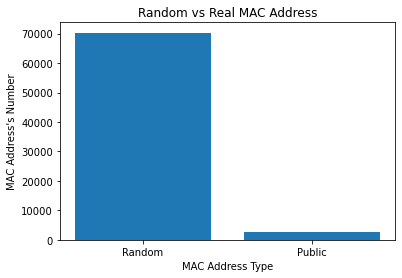

In [118]:
MACTypeData = data.groupby(pd.Grouper(key='Tipo MAC')).count()

plt.bar(MACTypeData.index, MACTypeData.MAC)
plt.xlabel("MAC Address Type")
plt.ylabel("MAC Address's Number")
plt.title("Random vs Real MAC Address")
plt.show()

Existe una clara victoria para las direcciones MAC aleatorias de todas las tramas recogidas por el ESP32. 

Dado la poca cantidad de direcciones MAC públicas, es posible eliminarlas del conjunto de datos para intentar reducir información poco relevante. Para ello, vamos a representar la evolución del número de dispositivos teniendo en cuenta todas las MAcs y solamente las privadas o aleatorias.

Al representar el número de direcciones MAC únicas en un periodo corto de tiempo, conseguimos una aproximación burda del número de dispositivos a lo largo del tiempo. Estas divisiones serán de 5 minutos.

Con la ayuda de un contador de personas instalado la puerta de la biblioteca, se ha realizado una medición de cuantas personas hay dentro. Podemos representar la evolución de este dato para comprobar si tiene una forma similar a la obtenida con los receptores BLE:

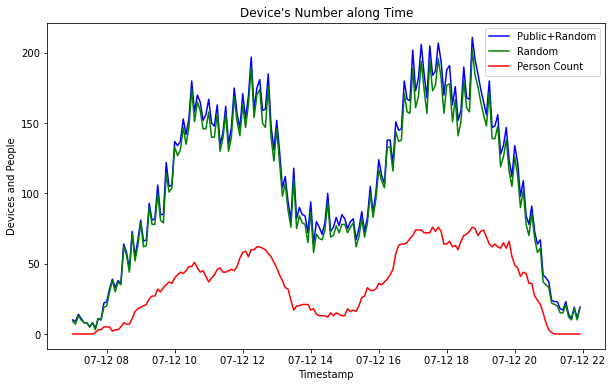

In [119]:
nDevicesIntervalData = data.groupby(pd.Grouper(key='Timestamp int.')).nunique()
nDevicesIntervalDataRand = data.loc[data['Tipo MAC'] == 'Random']
nDevicesIntervalDataRand = nDevicesIntervalDataRand.groupby(pd.Grouper(key='Timestamp int.')).nunique()
plt.figure(figsize=(10,6))
plt.plot(nDevicesIntervalData.index, nDevicesIntervalData.MAC, color='blue', label='Public+Random')
plt.plot(nDevicesIntervalDataRand.index, nDevicesIntervalDataRand.MAC, color='green', label='Random')
plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
plt.xlabel("Timestamp")
plt.ylabel("Devices and People")
plt.title("Device's Number along Time")
plt.legend()
plt.show()

Como se puede ver, la forma de la gráfica no varía y lo único que varía es la amplitud. Por tanto, podemos asegurar que las direcciones MAC públicas son desechables, lo que aunque no parezca suponer un gran cambio, es una ayuda a eliminar datos irrelevantes.

Para tener una visión más específica de dónde se concentran los dispositivos, vamos a aprovechar el hecho de tener repartidos los receptores en distintas localizaciones para visualizar la evolución de cada uno de los receptores:

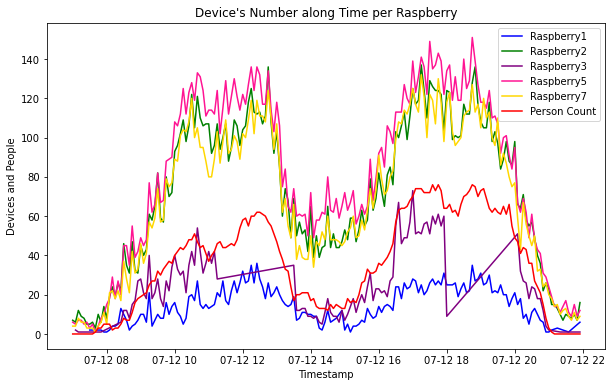

In [120]:
nDevicesIntervalDataRand = data.loc[data['Tipo MAC'] == 'Random']

nDevicesIntervalDataRaspberry1Raw = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry1']
nDevicesRaspberry1 = len(nDevicesIntervalDataRaspberry1Raw.groupby("MAC").count())
nDevicesIntervalDataRaspberry1 = nDevicesIntervalDataRaspberry1Raw.groupby(['Timestamp int.']).nunique()

nDevicesIntervalDataRaspberry2Raw = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry2']
nDevicesRaspberry2 = len(nDevicesIntervalDataRaspberry2Raw.groupby("MAC").count())
nDevicesIntervalDataRaspberry2 = nDevicesIntervalDataRaspberry2Raw.groupby(['Timestamp int.']).nunique()

nDevicesIntervalDataRaspberry3Raw = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry3']
nDevicesRaspberry3 = len(nDevicesIntervalDataRaspberry3Raw.groupby("MAC").count())
nDevicesIntervalDataRaspberry3 = nDevicesIntervalDataRaspberry3Raw.groupby(['Timestamp int.']).nunique()

nDevicesIntervalDataRaspberry5Raw = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry5']
nDevicesRaspberry5 = len(nDevicesIntervalDataRaspberry5Raw.groupby("MAC").count())
nDevicesIntervalDataRaspberry5 = nDevicesIntervalDataRaspberry5Raw.groupby(['Timestamp int.']).nunique()

nDevicesIntervalDataRaspberry7Raw = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry7']
nDevicesRaspberry7 = len(nDevicesIntervalDataRaspberry7Raw.groupby("MAC").count())
nDevicesIntervalDataRaspberry7 = nDevicesIntervalDataRaspberry7Raw.groupby(['Timestamp int.']).nunique()

plt.figure(figsize=(10,6))
plt.plot(nDevicesIntervalDataRaspberry1.index, nDevicesIntervalDataRaspberry1.MAC, color='blue', label='Raspberry1')
plt.plot(nDevicesIntervalDataRaspberry2.index, nDevicesIntervalDataRaspberry2.MAC, color='green', label='Raspberry2')
plt.plot(nDevicesIntervalDataRaspberry3.index, nDevicesIntervalDataRaspberry3.MAC, color='purple', label='Raspberry3')
plt.plot(nDevicesIntervalDataRaspberry5.index, nDevicesIntervalDataRaspberry5.MAC, color='deeppink', label='Raspberry5')
plt.plot(nDevicesIntervalDataRaspberry7.index, nDevicesIntervalDataRaspberry7.MAC, color='gold', label='Raspberry7')
plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
plt.xlabel("Timestamp")
plt.ylabel("Devices and People")
plt.title("Device's Number along Time per Raspberry")
plt.legend()
plt.show()

Observando el resultado obtenido, vemos que tiene sentido que tanto a tempranas como a altas horas del día (antes de las 08:00 y a partir de las 21:00 h cuando la biblioteca cierra) el número de dispositivos capturados decrezca.

Además, los datos tienen dos claros picos de actividad, situados entre las 10:00 h-13:00 h y 16:00 h-19:00 h. Vamos a hacer Zoom a una de las zonas mencionadas:

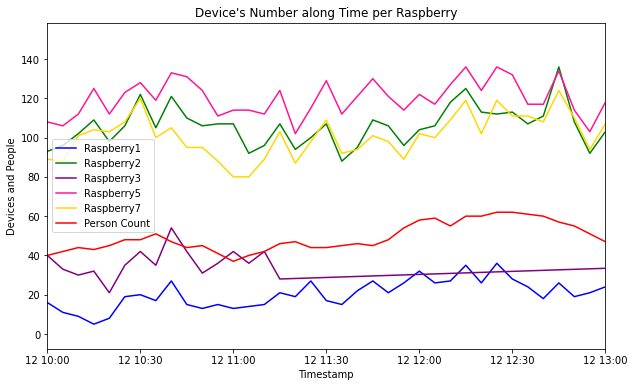

In [121]:
initialDate = dt.datetime(2022, 7, 12, hour=10) # Aquí podemos modificar la hora de comienzo
finalDate = dt.datetime(2022, 7, 12, hour=13) # Aquí podemos modificar la hora de final

plt.figure(figsize=(10,6))
plt.plot(nDevicesIntervalDataRaspberry1.index, nDevicesIntervalDataRaspberry1.MAC, color='blue', label='Raspberry1')
plt.plot(nDevicesIntervalDataRaspberry2.index, nDevicesIntervalDataRaspberry2.MAC, color='green', label='Raspberry2')
plt.plot(nDevicesIntervalDataRaspberry3.index, nDevicesIntervalDataRaspberry3.MAC, color='purple', label='Raspberry3')
plt.plot(nDevicesIntervalDataRaspberry5.index, nDevicesIntervalDataRaspberry5.MAC, color='deeppink', label='Raspberry5')
plt.plot(nDevicesIntervalDataRaspberry7.index, nDevicesIntervalDataRaspberry7.MAC, color='gold', label='Raspberry7')
plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
plt.xlabel("Timestamp")
plt.xlim(initialDate, finalDate)
plt.ylabel("Devices and People")
plt.title("Device's Number along Time per Raspberry")
plt.legend()
plt.show()

La potencia con la que se captan las tramas también nos puede aportar mucha información, puede indicar que un dispositivo se está alejando o acercando a un receptor, o tal vez que se encuentra fuera del lugar de estudio.

Por ello también sería interesante visualizar tanto el número de paquetes recibidos por un dispositivo como la potencia con la que llegan, ya que si se encuentran pocos paquetes con poca potencia de un dispositivo, seguramente se traten de dispositivos externos o poco relevantes que se pueden eliminar para el cálculo, incorporarlos podría generar ruido en el procesado posterior.

Comenzaremos mostrando la evolución en el número de dispositivos contenidos en unos rangos de potencia:

**** PROBLEMA ****
ES POSIBLE QUE EXISTAN DISPOSITIVOS QUE ENVÍEN TRAMAS CON DISTINTOS NIVELES DE SEÑAL (QUE ESTÉN MÁS CERCA O MÁS LEJOS DEL RECEPTOR), POR LO QUE SALDRÁN REPETIDOS EN EL CONTEO GENERAL. ¿CÓMO SE PUEDE ABORDAR ESTO?

1918
3878
3639
2839
1702
448


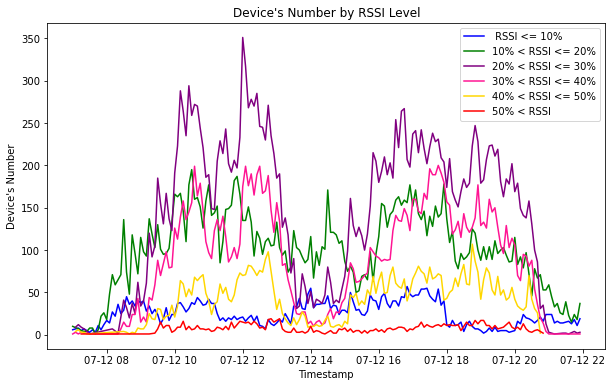

In [122]:
minRSSI = nDevicesIntervalDataRand["RSSI promedio"].min()

rssiDeviceInterval1 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["RSSI promedio"] <= minRSSI - minRSSI*0.1)]
nDevices1 = rssiDeviceInterval1.groupby("MAC").count()
print(len(nDevices1))
rssiDeviceInterval1 = rssiDeviceInterval1.groupby("Timestamp int.").count()

rssiDeviceInterval2 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["RSSI promedio"] > minRSSI - minRSSI*0.1) & (nDevicesIntervalDataRand["RSSI promedio"] <= minRSSI - minRSSI*0.2)]
nDevices2 = rssiDeviceInterval2.groupby("MAC").count()
print(len(nDevices2))
rssiDeviceInterval2 = rssiDeviceInterval2.groupby("Timestamp int.").count()

rssiDeviceInterval3 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["RSSI promedio"] > minRSSI - minRSSI*0.2) & (nDevicesIntervalDataRand["RSSI promedio"] <= minRSSI - minRSSI*0.3)]
nDevices3 = rssiDeviceInterval3.groupby("MAC").count()
print(len(nDevices3))
rssiDeviceInterval3 = rssiDeviceInterval3.groupby("Timestamp int.").count()

rssiDeviceInterval4 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["RSSI promedio"] > minRSSI - minRSSI*0.3) & (nDevicesIntervalDataRand["RSSI promedio"] <= minRSSI - minRSSI*0.4)]
nDevices4 = rssiDeviceInterval4.groupby("MAC").count()
print(len(nDevices4))
rssiDeviceInterval4 = rssiDeviceInterval4.groupby("Timestamp int.").count()

rssiDeviceInterval5 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["RSSI promedio"] > minRSSI - minRSSI*0.4) & (nDevicesIntervalDataRand["RSSI promedio"] <= minRSSI - minRSSI*0.5)]
nDevices5 = rssiDeviceInterval5.groupby("MAC").count()
print(len(nDevices5))
rssiDeviceInterval5 = rssiDeviceInterval5.groupby("Timestamp int.").count()

rssiDeviceInterval6 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand["RSSI promedio"] > minRSSI - minRSSI*0.5]
nDevices6 = rssiDeviceInterval6.groupby("MAC").count()
print(len(nDevices6))
rssiDeviceInterval6 = rssiDeviceInterval6.groupby("Timestamp int.").count()

plt.figure(figsize=(10,6))
plt.plot(rssiDeviceInterval1.index, rssiDeviceInterval1.MAC, color='blue', label=' RSSI <= 10%')
plt.plot(rssiDeviceInterval2.index, rssiDeviceInterval2.MAC, color='green', label='10% < RSSI <= 20%')
plt.plot(rssiDeviceInterval3.index, rssiDeviceInterval3.MAC, color='purple', label='20% < RSSI <= 30%')
plt.plot(rssiDeviceInterval4.index, rssiDeviceInterval4.MAC, color='deeppink', label='30% < RSSI <= 40%')
plt.plot(rssiDeviceInterval5.index, rssiDeviceInterval5.MAC, color='gold', label='40% < RSSI <= 50%')
plt.plot(rssiDeviceInterval6.index, rssiDeviceInterval6.MAC, color='red', label='50% < RSSI')
plt.xlabel("Timestamp")
plt.ylabel("Device's Number")
plt.title("Device's Number by RSSI Level")
plt.legend()
plt.show()

Por ejemplo, los dispositivos con una potencia entre el valor mínimo y un 10% por encima son candidatos a ser eliminados del conjunto si además cumplen con la condición de tener un número de mensajes bajo.

Si nos centramos en el caso particular de cada receptor, podemos conseguir los siguientes resultados:

Text(0.5, 1.0, 'Raspberry7')

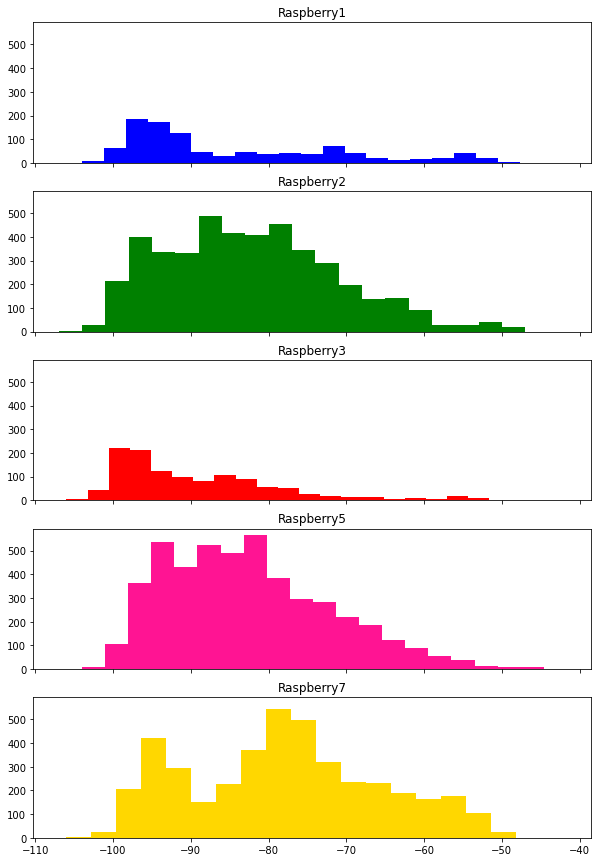

In [123]:
bins=20
rssiDeviceIntervalRaspberry1 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry1']
rssiDeviceIntervalRaspberry1 = rssiDeviceIntervalRaspberry1.groupby(pd.Grouper(key='MAC')).mean()
rssiDeviceIntervalRaspberry2 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry2']
rssiDeviceIntervalRaspberry2 = rssiDeviceIntervalRaspberry2.groupby(pd.Grouper(key='MAC')).mean()
rssiDeviceIntervalRaspberry3 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry3']
rssiDeviceIntervalRaspberry3 = rssiDeviceIntervalRaspberry3.groupby(pd.Grouper(key='MAC')).mean()
rssiDeviceIntervalRaspberry5 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry5']
rssiDeviceIntervalRaspberry5 = rssiDeviceIntervalRaspberry5.groupby(pd.Grouper(key='MAC')).mean()
rssiDeviceIntervalRaspberry7 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand['Raspberry'] == 'Raspberry7']
rssiDeviceIntervalRaspberry7 = rssiDeviceIntervalRaspberry7.groupby(pd.Grouper(key='MAC')).mean()

figure, axis = plt.subplots(5, 1, sharex=True, sharey=True)
figure.set_size_inches(10,15)
axis[0].hist(rssiDeviceIntervalRaspberry1['RSSI promedio'], bins, color='blue')
axis[0].set_title("Raspberry1")
axis[1].hist(rssiDeviceIntervalRaspberry2['RSSI promedio'], bins, color='green')
axis[1].set_title("Raspberry2")
axis[2].hist(rssiDeviceIntervalRaspberry3['RSSI promedio'], bins, color='red')
axis[2].set_title("Raspberry3")
axis[3].hist(rssiDeviceIntervalRaspberry5['RSSI promedio'], bins, color='deeppink')
axis[3].set_title("Raspberry5")
axis[4].hist(rssiDeviceIntervalRaspberry7['RSSI promedio'], bins, color='gold')
axis[4].set_title("Raspberry7")

Para continuar con lo anterior, necesitamos representar el número de mensajes recibidos por cada dispositivo. Sin embargo, esto puede ser costoso, ya que en cada conjunto de datos puede haber muchos dispositivos (miles) lo cual hace imposible su representación. Una posible solución es representar el número de dispositivos que han enviado un cierto número de mensajes, de manera similar al apartado anterior:

**** PROBLEMA ****
ES POSIBLE QUE EXISTAN DISPOSITIVOS QUE ENVÍEN DISTINTOS NÚMERO DE MENSAJES (QUE ESTÉN MÁS CERCA O MÁS LEJOS DEL RECEPTOR), POR LO QUE SALDRÁN REPETIDOS EN EL CONTEO GENERAL. ¿CÓMO SE PUEDE ABORDAR ESTO?

5592
2001
1147
851
712
1214


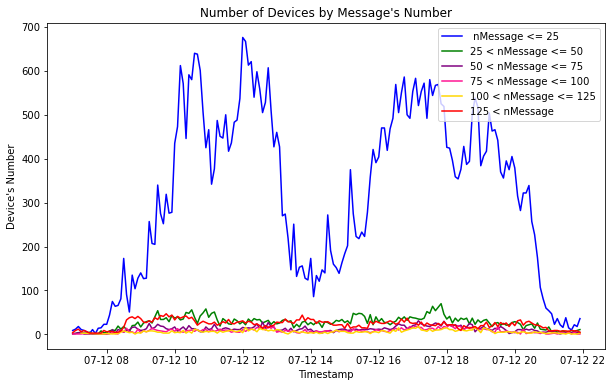

In [124]:
messageDeviceInterval1 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["Nº Mensajes"] <= 25)]
nDevices1 = messageDeviceInterval1.groupby("MAC").count()
print(len(nDevices1))
messageDeviceInterval1 = messageDeviceInterval1.groupby("Timestamp int.").count()

messageDeviceInterval2 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["Nº Mensajes"] > 25) & (nDevicesIntervalDataRand["Nº Mensajes"] <= 50)]
nDevices2 = messageDeviceInterval2.groupby("MAC").count()
print(len(nDevices2))
messageDeviceInterval2 = messageDeviceInterval2.groupby("Timestamp int.").count()

messageDeviceInterval3 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["Nº Mensajes"] > 50) & (nDevicesIntervalDataRand["Nº Mensajes"] <= 75)]
nDevices3 = messageDeviceInterval3.groupby("MAC").count()
print(len(nDevices3))
messageDeviceInterval3 = messageDeviceInterval3.groupby("Timestamp int.").count()

messageDeviceInterval4 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["Nº Mensajes"] > 75) & (nDevicesIntervalDataRand["Nº Mensajes"] <= 100)]
nDevices4 = messageDeviceInterval4.groupby("MAC").count()
print(len(nDevices4))
messageDeviceInterval4 = messageDeviceInterval4.groupby("Timestamp int.").count()

messageDeviceInterval5 = nDevicesIntervalDataRand.loc[(nDevicesIntervalDataRand["Nº Mensajes"] > 100) & (nDevicesIntervalDataRand["Nº Mensajes"] <= 125)]
nDevices5 = messageDeviceInterval5.groupby("MAC").count()
print(len(nDevices5))
messageDeviceInterval5 = messageDeviceInterval5.groupby("Timestamp int.").count()

messageDeviceInterval6 = nDevicesIntervalDataRand.loc[nDevicesIntervalDataRand["Nº Mensajes"] > 125]
nDevices6 = messageDeviceInterval6.groupby("MAC").count()
print(len(nDevices6))
messageDeviceInterval6 = messageDeviceInterval6.groupby("Timestamp int.").count()

plt.figure(figsize=(10,6))
plt.plot(messageDeviceInterval1.index, messageDeviceInterval1['Nº Mensajes'], color='blue', label=' nMessage <= 25')
plt.plot(messageDeviceInterval2.index, messageDeviceInterval2['Nº Mensajes'], color='green', label='25 < nMessage <= 50')
plt.plot(messageDeviceInterval3.index, messageDeviceInterval3['Nº Mensajes'], color='purple', label='50 < nMessage <= 75')
plt.plot(messageDeviceInterval4.index, messageDeviceInterval4['Nº Mensajes'], color='deeppink', label='75 < nMessage <= 100')
plt.plot(messageDeviceInterval5.index, messageDeviceInterval5['Nº Mensajes'], color='gold', label='100 < nMessage <= 125')
plt.plot(messageDeviceInterval6.index, messageDeviceInterval6['Nº Mensajes'], color='red', label='125 < nMessage')
plt.xlabel("Timestamp")
plt.ylabel("Device's Number")
plt.title("Number of Devices by Message's Number")
plt.legend()
plt.show()

Como se puede ver, existen un gran número de dispositivos que emiten 25 mensajes o menos en el mismo periodo de tiempo. Podría ser buena idea aumentar la resolución de esta medida, acortando el rango para poder visualizar más en detalle como se distribuyen los dispositivos.

A partir de ahora, nos centraremos en los receptores desplegados en la principal sala de estudio, es decir, *Raspberry2*, *Raspberry7*, *Raspberry7*. Dado que comparten cobertura y sus evoluciones temporales son parecidas, podemos sacar algunas conclusiones a partir de los datos que nos aportan.

Por ejemplo, el número de direcciones MAC que encuentra cada receptor, que tanto por ciento de paquetes están por debajo de un umbral de potencia, saber si un dispositivo se ha registrado a la vez en más de un receptor o el tanto por ciento de dispositivos que ya estaban registrados durante el intervalo anterior.

In [125]:
RSSIThreshold = -99
print("Número dispositivos captados por la Raspberry2:", nDevicesRaspberry2)
print("Número dispositivos captados por la Raspberry5:", nDevicesRaspberry5)
print("Número dispositivos captados por la Raspberry7:", nDevicesRaspberry7)
print('')

nMessageRaspberry2 = nDevicesIntervalDataRaspberry2Raw["Nº Mensajes"].sum()
nMessageRaspberry5 = nDevicesIntervalDataRaspberry5Raw["Nº Mensajes"].sum()
nMessageRaspberry7 = nDevicesIntervalDataRaspberry7Raw["Nº Mensajes"].sum()
print("Número de mensajes captados por la Raspberry2:", nMessageRaspberry2)
print("Número de mensajes captados por la Raspberry5:", nMessageRaspberry5)
print("Número de mensajes captados por la Raspberry7:", nMessageRaspberry7)
print('')

filterRaspberry2 = nDevicesIntervalDataRaspberry2Raw.loc[nDevicesIntervalDataRaspberry2Raw["RSSI promedio"] < RSSIThreshold]
nMessageFilterRaspberry2 = filterRaspberry2["Nº Mensajes"].sum()

filterRaspberry5 = nDevicesIntervalDataRaspberry5Raw.loc[nDevicesIntervalDataRaspberry5Raw["RSSI promedio"] < RSSIThreshold]
nMessageFilterRaspberry5 = filterRaspberry5["Nº Mensajes"].sum()

filterRaspberry7 = nDevicesIntervalDataRaspberry7Raw.loc[nDevicesIntervalDataRaspberry7Raw["RSSI promedio"] < RSSIThreshold]
nMessageFilterRaspberry7 = filterRaspberry7["Nº Mensajes"].sum()

print("Tanto por ciento de mensajes por debajo de -99 dB en Raspberry2:", np.round(nMessageFilterRaspberry2/nMessageRaspberry2*100, 4), "%")
print("Tanto por ciento de mensajes por debajo de -99 dB en Raspberry5:", np.round(nMessageFilterRaspberry5/nMessageRaspberry5*100, 4), "%")
print("Tanto por ciento de mensajes por debajo de -99 dB en Raspberry7:", np.round(nMessageFilterRaspberry7/nMessageRaspberry7*100, 4), "%")
print('')

nDeviceRaspberry2 = nDevicesIntervalDataRaspberry2Raw["MAC"].count()
nDeviceRaspberry5 = nDevicesIntervalDataRaspberry5Raw["MAC"].count()
nDeviceRaspberry7 = nDevicesIntervalDataRaspberry7Raw["MAC"].count()
nDeviceFilterRaspberry2 = filterRaspberry2["MAC"].count()
nDeviceFilterRaspberry5 = filterRaspberry5["MAC"].count()
nDeviceFilterRaspberry7 = filterRaspberry7["MAC"].count()
print("Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry2:", np.round(nDeviceFilterRaspberry2/nDeviceRaspberry2*100, 4), "%")
print("Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry5:", np.round(nDeviceFilterRaspberry5/nDeviceRaspberry5*100, 4), "%")
print("Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry7:", np.round(nDeviceFilterRaspberry7/nDeviceRaspberry7*100, 4), "%")
print('')


Número dispositivos captados por la Raspberry2: 4400
Número dispositivos captados por la Raspberry5: 4733
Número dispositivos captados por la Raspberry7: 4191

Número de mensajes captados por la Raspberry2: 442056
Número de mensajes captados por la Raspberry5: 636158
Número de mensajes captados por la Raspberry7: 424340

Tanto por ciento de mensajes por debajo de -99 dB en Raspberry2: 0.2414 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry5: 0.0539 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry7: 0.0504 %

Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry2: 1.42 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry5: 0.6622 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry7: 0.5082 %



Como se ha comentado anteriormente, un aspecto que nos puede dar confianza es que un mismo dispositivo sea detectado por más de un receptor en el mismo intervalo de tiempo, para ello recorreremos el datasheet dividido en intervalos de tiempo, comprobando por cuantos y cuáles receptores ha sido capturado ese mensaje:

**** SUGERENCIA ****
Se puede añadir alguna gráfica para visualizar los datos, aunque el dataframe generado es correcto y sirve para operar con él.

In [126]:
nDevicesIntervalDataRaspberry2Merge = nDevicesIntervalDataRaspberry2Raw.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)
nDevicesIntervalDataRaspberry5Merge = nDevicesIntervalDataRaspberry5Raw.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)
nDevicesIntervalDataRaspberry7Merge = nDevicesIntervalDataRaspberry7Raw.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)

nDevicesIntervalDataRaspberry2_5Merge = nDevicesIntervalDataRaspberry2Merge.merge(nDevicesIntervalDataRaspberry5Merge, how='outer', on=("Timestamp int.", "MAC"), copy=False)
nDevicesIntervalDataRaspberry2_5_7Merge = nDevicesIntervalDataRaspberry2_5Merge.merge(nDevicesIntervalDataRaspberry7Merge, how='outer', on=("Timestamp int.","MAC"), copy=False)
deviceSummary = pd.DataFrame(columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])

for i in range(len(timeSeries)):
    group = nDevicesIntervalDataRaspberry2_5_7Merge.loc[nDevicesIntervalDataRaspberry2_5_7Merge["Timestamp int."] == timeSeries[i]]
    group = group.groupby(["Timestamp int.", "MAC"]).nunique()
    for j in range(len(group)):
        name = "Raspberry"
        total = 0
        if group["Raspberry_x"][j] == 1:
            name = name + "_2"
            total = total + 1
        if group["Raspberry_y"][j] == 1:
            name = name + "_5"
            total = total + 1
        if group["Raspberry"][j] == 1:
            name = name + "_7"
            total = total + 1
        df = pd.DataFrame([[timeSeries[i], group.index[j][1], name, total]],
                           columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])
        deviceSummary = pd.concat([deviceSummary, df], ignore_index=True)
print(deviceSummary.head(10))

             Timestamp                MAC        Raspberry Total
0  2022-07-12 07:00:00  14:1b:f4:3c:f3:b5      Raspberry_5     1
1  2022-07-12 07:00:00  45:63:10:5b:19:8d      Raspberry_2     1
2  2022-07-12 07:00:00  66:68:ef:e1:40:19      Raspberry_2     1
3  2022-07-12 07:00:00  6b:47:3e:09:e4:ec  Raspberry_2_5_7     3
4  2022-07-12 07:00:00  6c:81:e5:45:1c:92  Raspberry_2_5_7     3
5  2022-07-12 07:00:00  7f:1c:1a:a0:6e:66      Raspberry_5     1
6  2022-07-12 07:00:00  c2:ce:06:f1:94:c4      Raspberry_2     1
7  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a  Raspberry_2_5_7     3
8  2022-07-12 07:00:00  e1:b1:0f:14:75:7d  Raspberry_2_5_7     3
9  2022-07-12 07:05:00  66:68:ef:e1:40:19      Raspberry_2     1


Al igual que es importante saber si un dispositivo se ha registrado en un mismo receptor en el mismo instante de tiempo, es interesante saber si ese dispositivo estaba previamente registrado, es decir, la continuidad del dispositivo en un receptor a lo largo de los instantes de tiempo, lo que indica que no se ha movido del lugar dándonos más confianza en el dato.

**** SUGERENCIA ****
Se puede añadir alguna gráfica para visualizar los datos, aunque el dataframe generado es correcto y sirve para operar con él.

In [127]:
devicesInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'Rate'])
devicesMACInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'MAC', 'isIn'])

for i in range(len(timeSeries)):
    if i == 0:
        MACList = deviceSummary.loc[deviceSummary["Timestamp"] == timeSeries[i]]["MAC"]
        for z in range(len(MACList)):
            df2 = pd.DataFrame([[timeSeries[i], MACList[z], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
            devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
        df = pd.DataFrame([[timeSeries[i], '0 %']], columns=['Timestamp', 'Rate'])
        devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)
    else:
        group = deviceSummary.loc[deviceSummary["Timestamp"] == timeSeries[i]]
        groupToCheck = deviceSummary.loc[deviceSummary["Timestamp"] == timeSeries[i-1]]
        count = 0
        for j in np.array(group.index):
            isDetected = groupToCheck.loc[groupToCheck["MAC"] == group["MAC"][j]]
            if len(isDetected) != 0:
                count = count + 1
                df2 = pd.DataFrame([[timeSeries[i], group["MAC"][j], 'Y']], columns=['Timestamp', 'MAC', 'isIn'])
                devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
            else:
                df2 = pd.DataFrame([[timeSeries[i], group["MAC"][j], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
                devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
        rate = str(np.round(count / len(group) * 100, 3)) + ' %'
        df = pd.DataFrame([[timeSeries[i], rate]], columns=['Timestamp', 'Rate'])
        devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)

print(devicesInPreviousInterval.head(20))
print(devicesMACInPreviousInterval.head(20))


              Timestamp      Rate
0   2022-07-12 07:00:00       0 %
1   2022-07-12 07:05:00  71.429 %
2   2022-07-12 07:10:00  53.846 %
3   2022-07-12 07:15:00    60.0 %
4   2022-07-12 07:20:00    87.5 %
5   2022-07-12 07:25:00    87.5 %
6   2022-07-12 07:30:00    60.0 %
7   2022-07-12 07:35:00    50.0 %
8   2022-07-12 07:40:00   100.0 %
9   2022-07-12 07:45:00  27.273 %
10  2022-07-12 07:50:00    30.0 %
11  2022-07-12 07:55:00  44.444 %
12  2022-07-12 08:00:00  57.895 %
13  2022-07-12 08:05:00  32.143 %
14  2022-07-12 08:10:00  52.778 %
15  2022-07-12 08:15:00  34.615 %
16  2022-07-12 08:20:00  34.375 %
17  2022-07-12 08:25:00  65.517 %
18  2022-07-12 08:30:00  33.333 %
19  2022-07-12 08:35:00   50.98 %
              Timestamp                MAC isIn
0   2022-07-12 07:00:00  14:1b:f4:3c:f3:b5    N
1   2022-07-12 07:00:00  45:63:10:5b:19:8d    N
2   2022-07-12 07:00:00  66:68:ef:e1:40:19    N
3   2022-07-12 07:00:00  6b:47:3e:09:e4:ec    N
4   2022-07-12 07:00:00  6c:81:e5:45:1c:92    

Los mapas de correlación son de mucha ayuda, ya que muestran cuan estrecha es la relación entre las columnas de datos. Podemos obtener fácilmente este mapa con lo siguiente:

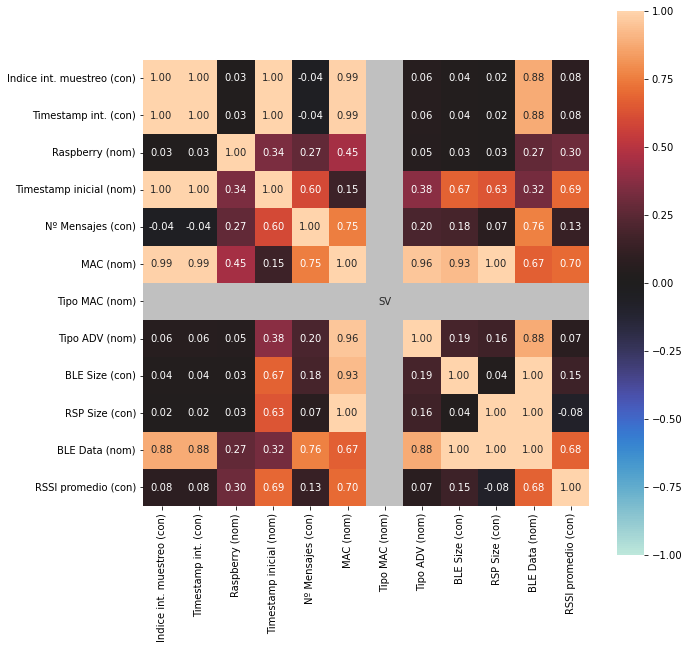

In [128]:
associations(nDevicesIntervalDataRand, figsize=(10, 10), mark_columns=True);